In [1]:
#import models
import numpy as np
import h5py
import sys, os
import rospy
import rosbag
import math
from scipy.interpolate import interp1d
import h5py
import matplotlib.pylab as plt

#sys.path.insert(0, '/media/abdulla/Seagate Expansion Drive/DVS research/DATA/contact estimation/')
from EventPreProcess import EventPreProcess
from dvs_msgs.msg import EventArray
from std_msgs.msg import Float64, Bool
from geometry_msgs.msg import Pose, Vector3, PoseStamped

In [4]:
#parameters of processing
frequency = 10 #Hz
bag_file_name = 'tactile_sensing_data/17_point_contact_estimation_new_proto.bag'
h5_file_name = '17_point_single_frame_processed_data_new_prototype.hdf5'
time_window_size = 15
examples_per_edge = 3

In [5]:
bag_file = rosbag.Bag(bag_file_name)

events = []
contact_status = []
contact_status_ts = []
contact_case = [] #0:No contact 1: center, 2:remainder of contacts as in list_of_rotations
contact_case_ts = []

#generate labels
possible_angle = [0.1, 0.25]
N_examples = 9
list_of_rotations = [[0, 0, 0]]

for i in range(1, N_examples):
    theta = i * 2 * math.pi/(N_examples - 1)
    for phi in possible_angle:
        rx = phi * math.cos(theta)
        ry = phi * math.sin(theta)
        rotvec = [rx, ry, 0]
        list_of_rotations.append(rotvec)

print(list_of_rotations)


[[0, 0, 0], [0.07071067811865477, 0.07071067811865475, 0], [0.1767766952966369, 0.17677669529663687, 0], [6.123233995736766e-18, 0.1, 0], [1.5308084989341915e-17, 0.25, 0], [-0.07071067811865475, 0.07071067811865477, 0], [-0.17677669529663687, 0.1767766952966369, 0], [-0.1, 1.2246467991473533e-17, 0], [-0.25, 3.061616997868383e-17, 0], [-0.07071067811865477, -0.07071067811865475, 0], [-0.17677669529663692, -0.17677669529663687, 0], [-1.8369701987210297e-17, -0.1, 0], [-4.592425496802574e-17, -0.25, 0], [0.07071067811865474, -0.07071067811865477, 0], [0.17677669529663684, -0.17677669529663692, 0], [0.1, -2.4492935982947065e-17, 0], [0.25, -6.123233995736766e-17, 0]]


In [6]:
#parse rosbag

for topic, msg, t in bag_file.read_messages(topics=['/contact_status', '/dvs/events', '/contact_angle']):
    if topic == '/dvs/events':
        for e in msg.events:
            event = [e.x, e.y, e.ts.to_nsec(), e.polarity]
            events.append(event)
    elif topic == '/contact_status':
        contact_status.append(msg.data)
        contact_status_ts.append(t.to_nsec())
    elif topic == '/contact_angle':
        if (len(contact_status) > 1):
            if (contact_status[-1] == True):
                best_rot_diff = 100
                best_rot_idx = 1
                i = 1
                for rot in list_of_rotations:
                    diff_vals = np.sqrt( np.power(rot[0] - msg.x, 2) +  np.power(rot[1] - msg.y, 2) + np.power(rot[2] - msg.z, 2) )
                    if best_rot_diff > diff_vals:
                        best_rot_diff = diff_vals
                        best_rot_idx = i
                    i = i + 1

                contact_case.append(best_rot_idx)
                contact_case_ts.append(t.to_nsec())
            else:
                contact_case.append(0)
                contact_case_ts.append(t.to_nsec())
        else:
            contact_case.append(0)
            contact_case_ts.append(t.to_nsec())

In [7]:
#interpolate
f = interp1d(contact_case_ts, contact_case, kind='previous')
contact_case_ts_int = range(min(contact_case_ts), max(contact_case_ts), int(1e9/frequency))
contact_case_int = f(contact_case_ts_int)

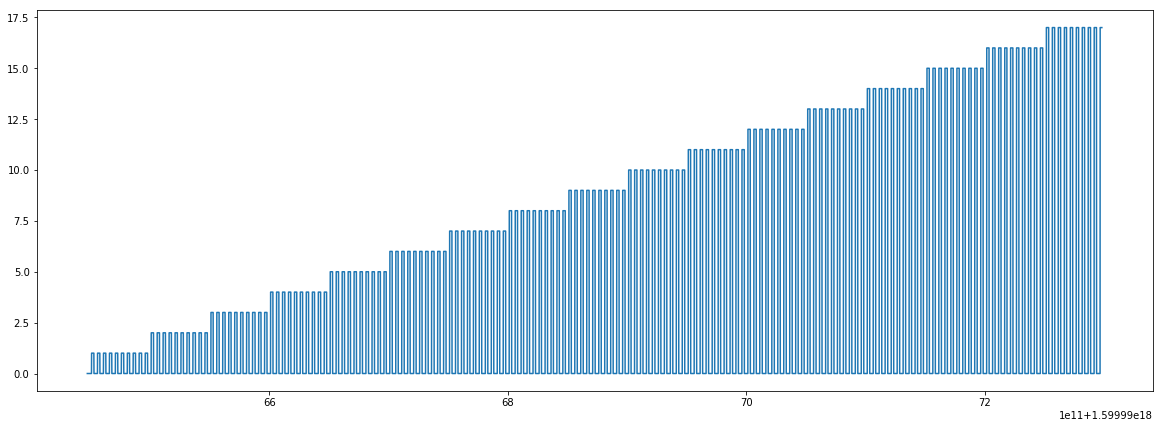

8507


In [8]:
plt.figure(figsize=(20,7))
plt.plot(contact_case_ts_int, contact_case_int)
plt.show()
print(len(contact_case_ts_int))

In [9]:
#Generate frames and store in h5 file
hf = h5py.File(h5_file_name, 'w')
hf.create_dataset('contact_status', data=contact_case_int)
hf.create_dataset('time_steps', data=contact_case_ts_int)

set_size = 1000
unprocessed_events = np.copy(events)

for i in range(0, len(contact_case_ts_int), set_size):
    start_idx=i
    end_idx=min([len(contact_case_ts_int), i+set_size])

    #[event_frames, unprocessed_events] = EventPreProcess.ConcatenateEvents(unprocessed_events, contact_case_ts_int[start_idx:end_idx])
    [event_frames, unprocessed_events] = EventPreProcess.generateFrames(unprocessed_events, contact_case_ts_int[start_idx:end_idx])
    #write data
    if i==0:
        print(np.shape(event_frames))
        hf.create_dataset('event_images', data=event_frames, maxshape=(None,None, None, None))
    else:
        hf['event_images'].resize(len(hf['event_images']) + len(event_frames), axis=0)
        hf["event_images"][-len(event_frames):] = event_frames
    del event_frames

hf.close()

Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage 

Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage 

Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage 

Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage 

Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 7
Percentage finished: 8
Percentage finished: 8
Percentage finished: 8
Percentage finished: 8
Percentage finished: 8
Percentage finished: 8
Percentage finished: 8
Percentage finished: 8
Percentage finished: 8
Percentage finished: 8
Percentage finished: 8
Percentage finished: 8
Percentage finished: 8
Percentage finished: 8
Percentage finished: 8
Percentage 

Percentage finished: 11
Percentage finished: 11
Percentage finished: 11
Percentage finished: 11
Percentage finished: 11
Percentage finished: 11
Percentage finished: 11
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finis

Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 2
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage 

Percentage finished: 8
Percentage finished: 8
Percentage finished: 8
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage 

Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finis

Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage 

Percentage finished: 11
Percentage finished: 11
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finished: 12
Percentage finis

Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 18
Percentage finished: 18
Percentage finished: 18
Percentage finished: 18
Percentage finished: 18
Percentage finished: 18
Percentage finished: 18
Percentage finished: 18
Percentage finished: 18
Percentage finished: 18
Percentage finished: 18
Percentage finished: 18
Percentage finis

Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage finished: 6
Percentage 

Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finis

Percentage finished: 19
Percentage finished: 19
Percentage finished: 19
Percentage finished: 19
Percentage finished: 19
Percentage finished: 19
Percentage finished: 19
Percentage finished: 19
Percentage finished: 19
Percentage finished: 19
Percentage finished: 19
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finis

Percentage finished: 9
Percentage finished: 9
Percentage finished: 9
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished: 10
Percentage finished

Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 20
Percentage finished: 21
Percentage finished: 21
Percentage finished: 21
Percentage finished: 21
Percentage finished: 21
Percentage finished: 21
Percentage finished: 21
Percentage finished: 21
Percentage finished: 21
Percentage finished: 21
Percentage finished: 21
Percentage finished: 21
Percentage finished: 21
Percentage finished: 21
Percentage finis

Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 28
Percentage finished: 28
Percentage finished: 28
Percentage finished: 28
Percentage finished: 28
Percentage finished: 28
Percentage finished: 28
Percentage finished: 28
Percentage finished: 28
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage finished: 0
Percentage fini

Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 14
Percentage finished: 15
Percentage finished: 15
Percentage finished: 15
Percentage finished: 15
Percentage finished: 15
Percentage finished: 15
Percentage finished: 15
Percentage finished: 15
Percentage finished: 15
Percentage finished: 15
Percentage finished: 15
Percentage finished: 15
Percentage finished: 15
Percentage finished: 15
Percentage finished: 15
Percentage finished: 15
Percentage finished: 15
Percentage finished: 15
Percentage finished: 15
Percentage finished: 15
Percentage finis

Percentage finished: 26
Percentage finished: 26
Percentage finished: 26
Percentage finished: 26
Percentage finished: 26
Percentage finished: 26
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finis

Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 1
Percentage finished: 2
Percentage finished: 2
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 3
Percentage finished: 4
Percentage finished: 4
Percentage finished: 4
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage finished: 5
Percentage 

Percentage finished: 26
Percentage finished: 26
Percentage finished: 26
Percentage finished: 26
Percentage finished: 26
Percentage finished: 26
Percentage finished: 26
Percentage finished: 26
Percentage finished: 26
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 27
Percentage finished: 28
Percentage finished: 28
Percentage finished: 29
Percentage finished: 29
Percentage finished: 29
Percentage finished: 29
Percentage finished: 29
Percentage finished: 29
Percentage finished: 29
Percentage finished: 29
Percentage finished: 29
Percentage finished: 29
Percentage finished: 29
Percentage finished: 29
Percentage finished: 29
Percentage finished: 29
Percentage finis

Percentage finished: 46
Percentage finished: 46
Percentage finished: 46
Percentage finished: 46
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 48
Percentage finished: 48
Percentage finished: 48
Percentage finished: 48
Percentage finished: 48
Percentage finished: 48
Percentage finished: 48
Percentage finished: 48
Percentage finished: 48
Percentage finished: 48
Percentage finished: 48
Percentage finished: 48
Percentage finished: 48
Percentage finished: 48
Percentage finished: 48
Percentage finished: 48
Percentage finished: 48
Percentage finished: 48
Percentage finished: 48
Percentage finis

Percentage finished: 13
Percentage finished: 13
Percentage finished: 13
Percentage finished: 15
Percentage finished: 16
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 17
Percentage finished: 18
Percentage finished: 18
Percentage finished: 18
Percentage finished: 18
Percentage finished: 18
Percentage finished: 20
Percentage finished: 21
Percentage finished: 21
Percentage finished: 22
Percentage finished: 22
Percentage finished: 22
Percentage finished: 22
Percentage finished: 22
Percentage finished: 22
Percentage finished: 22
Percentage finished: 22
Percentage finished: 22
Percentage finished: 22
Percentage finished: 22
Percentage finished: 22
Percentage finished: 22
Percentage finished: 22
Percentage finished: 22
Percentage finished: 22
Percentage finished: 22
Percentage finis

Percentage finished: 89
Percentage finished: 91
Percentage finished: 92
Percentage finished: 92
Percentage finished: 93
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 94
Percentage finished: 96
Percentage finished: 97
Percentage finished: 98
Percentage finished: 99
Percentage finished: 99
Percentage finished: 99
Percentage finished: 99
Percentage finished: 99
Percentage finis

In [10]:

hf = h5py.File(h5_file_name, 'r+')
print('number of event images: {}'.format(len(hf['event_images'])))
hf.close()

number of event images: 8507


In [11]:
#Find rise/drop time and create windows accordingle
edge_locations = np.where(np.abs(np.diff(contact_case_int))>0)
edge_locations = np.array(edge_locations)[0].tolist()
print(edge_locations)

#Divide the data set into windows

def extract_edge_data(hf_file, edge_index_list, n_examples_per_edge=examples_per_edge, window_size=time_window_size, n_classes=18):
    for i in range(len(edge_index_list)):
        index = edge_index_list[i]

        for j in range(n_examples_per_edge):
            if hf_file['contact_status'][index+1] == 0:
                #fall edge case
                start_index = max([0, math.floor(index+5)])
                end_index = start_index + window_size               
            else:
                #rise edge case
                start_index = max([0, math.floor(index-window_size/2)])
                end_index = start_index + window_size

            if end_index <= len(hf_file['contact_status']):
                reference_idx = range(int(start_index), int(end_index))
                one_hot_vector = [0] * n_classes
                one_hot_vector[int(hf_file['contact_status'][end_index])] = 1
                
                if not ('ex_input_image_idx' in hf_file.keys()):
                    hf_file.create_dataset('ex_input_image_idx', data=[reference_idx], maxshape=(None,None))
                    hf_file.create_dataset('ex_output', data=[one_hot_vector], maxshape=(None, None))
                else:
                    hf_file['ex_input_image_idx'].resize(len(hf_file['ex_input_image_idx']) + 1, axis=0)
                    hf_file["ex_input_image_idx"][len(hf_file['ex_input_image_idx'])-1] = reference_idx

                    hf_file['ex_output'].resize(len(hf_file['ex_output']) + 1, axis=0)
                    hf_file["ex_output"][len(hf_file['ex_output'])-1] = one_hot_vector

[35, 55, 85, 105, 135, 155, 185, 205, 235, 255, 285, 305, 335, 354, 384, 404, 434, 455, 485, 505, 535, 555, 585, 605, 635, 655, 685, 705, 735, 755, 785, 805, 835, 855, 885, 906, 936, 956, 986, 1006, 1036, 1055, 1085, 1105, 1135, 1155, 1185, 1205, 1235, 1255, 1285, 1305, 1335, 1355, 1385, 1406, 1436, 1456, 1486, 1506, 1536, 1556, 1586, 1606, 1636, 1656, 1686, 1706, 1736, 1756, 1785, 1805, 1835, 1855, 1886, 1905, 1936, 1956, 1986, 2006, 2036, 2056, 2086, 2106, 2136, 2156, 2186, 2206, 2236, 2256, 2286, 2306, 2336, 2357, 2387, 2407, 2437, 2457, 2487, 2506, 2536, 2556, 2586, 2606, 2636, 2656, 2686, 2706, 2736, 2756, 2786, 2806, 2836, 2857, 2886, 2907, 2937, 2957, 2987, 3007, 3037, 3057, 3087, 3107, 3137, 3157, 3187, 3207, 3237, 3256, 3286, 3306, 3337, 3357, 3387, 3407, 3437, 3457, 3487, 3507, 3537, 3557, 3587, 3607, 3637, 3657, 3687, 3707, 3737, 3757, 3788, 3807, 3838, 3858, 3888, 3907, 3937, 3957, 3987, 4007, 4037, 4057, 4087, 4107, 4137, 4157, 4187, 4207, 4237, 4257, 4288, 4308, 4338, 435

In [12]:
#Divide the data set into windows

def create_dataset(hf_file, time_steps=50, n_classes=18):
    for i in range(time_steps, len(hf_file['event_images']) - time_steps):
        if (i%1000) == 0:
            print(i/float(len(hf_file['event_images'])))
        reference_idx = range(i-time_steps+1,i+1)
        one_hot_vector = [0] * n_classes
        one_hot_vector[int(hf_file['contact_status'][i])] = 1
        
        if i==time_steps:
            hf_file.create_dataset('ex_input_image_idx', data=[reference_idx], maxshape=(None,None))
            hf_file.create_dataset('ex_output', data=[one_hot_vector], maxshape=(None, None))
        else:
            hf_file['ex_input_image_idx'].resize(len(hf_file['ex_input_image_idx']) + 1, axis=0)
            hf_file["ex_input_image_idx"][len(hf_file['ex_input_image_idx'])-1] = reference_idx

            hf_file['ex_output'].resize(len(hf_file['ex_output']) + 1, axis=0)
            hf_file["ex_output"][len(hf_file['ex_output'])-1] = one_hot_vector

In [13]:
hf = h5py.File(h5_file_name, 'r+')
extract_edge_data(hf, edge_locations)
hf.close()

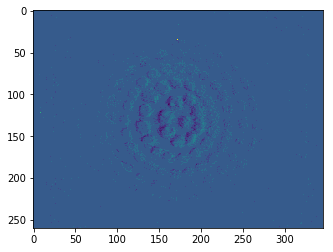

In [15]:
#Visualize events at switching states
hf = h5py.File(h5_file_name, 'r+')
indx = 91
plt.imshow(hf['event_images'][edge_locations[indx]][:,:,0])
plt.show
hf.close()

[507, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


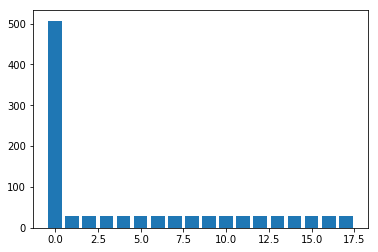

In [16]:
#analyze classes
hf = h5py.File(h5_file_name, 'r+')
counter = [0] * 18

for i in range(len(hf['ex_output'])):
    idx = list(hf['ex_output'][i]).index(1)
    counter[idx] = counter[idx] + 1

print(counter)
plt.bar(range(0,18),counter)
hf.close()

In [17]:
#Equalize representation of classes
hf = h5py.File(h5_file_name, 'r+')
def equalize_representation(hf_file, class_counter, n_classes=6):
    for i in range(len(hf_file['ex_output'])):
        idx = list(hf['ex_output'][i]).index(1)
        
        if (np.random.rand() < (float(min(counter)) / counter[idx])):
            if 'ex_input_image_idx_equalized' in hf_file.keys():
                hf_file['ex_input_image_idx_equalized'].resize(len(hf_file['ex_input_image_idx_equalized']) + 1, axis=0)
                hf_file["ex_input_image_idx_equalized"][len(hf_file['ex_input_image_idx_equalized'])-1] = hf_file['ex_input_image_idx'][i]

                hf_file['ex_output_equalized'].resize(len(hf_file['ex_output_equalized']) + 1, axis=0)
                hf_file["ex_output_equalized"][len(hf_file['ex_output_equalized'])-1] = hf['ex_output'][i]
            else:
                hf_file.create_dataset('ex_input_image_idx_equalized', data=[hf_file['ex_input_image_idx'][i]], maxshape=(None,None))
                hf_file.create_dataset('ex_output_equalized', data=[hf_file['ex_output'][i]], maxshape=(None, None))

equalize_representation(hf, counter)

[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


<Container object of 18 artists>

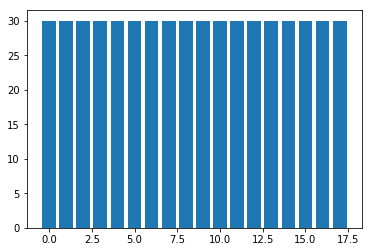

In [18]:
new_counter = [0] * 18

for i in range(len(hf['ex_output_equalized'])):
    idx = list(hf['ex_output_equalized'][i]).index(1)
    new_counter[idx] = new_counter[idx] + 1

print(new_counter)
plt.bar(range(0,18),new_counter)

In [19]:
print(len(hf['ex_output_equalized']))

540


In [20]:
hf.close()

In [30]:
hf = h5py.File(h5_file_name, 'r+')
del hf['ex_input_image_idx'] 
del hf['ex_output']
hf.close()

KeyError: "Couldn't delete link (callback link pointer is NULL (specified link may be '.' or not exist))"

In [33]:
print(np.mean(hf['event_images'][:,:,:,0]))
print(np.std(hf['event_images'][:,:,:,0]))
print(np.max(hf['event_images'][:,:,:,0]))
print(np.min(hf['event_images'][:,:,:,0]))


0.0008835273
0.031460017
21.0
0.0
